# Proof of concept of new "composable" ADMM formulation

3/30/21

This notebook is a proof of concept and understanding of the new ADMM formulation, based on grouping quadratic terms and linear constraints in with the global equality constraint. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import sparse as sp
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, PiecewiseConstant, SparseFirstDiffConvex, LaplaceNoise, Blank
from osd.generators import proj_l2_d2, make_pwc_data
from osd.utilities import progress

## Problem data generation

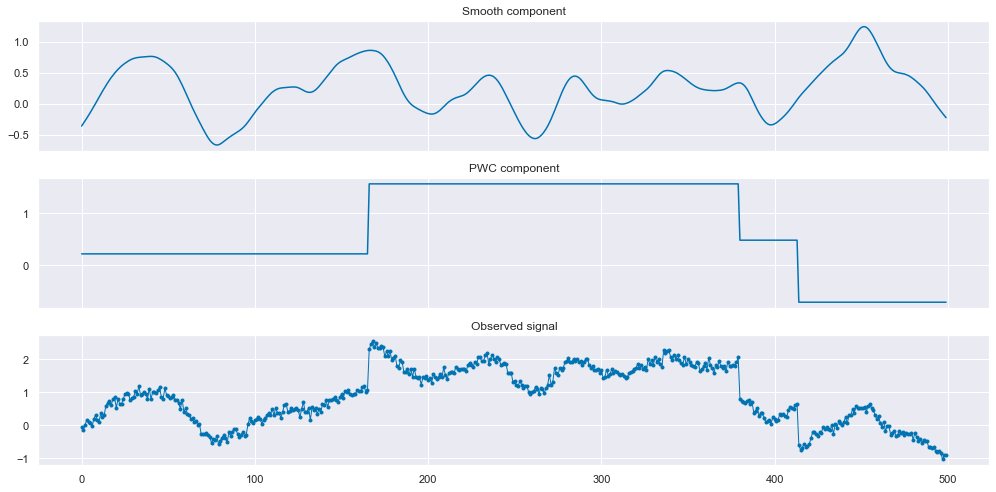

In [34]:
T = 500
X_real = np.zeros((3, T))
X_real[0] = 0.1 * np.random.randn(T)
X_real[1] = proj_l2_d2(np.random.randn(T), theta=5e2) * 2
X_real[2] = make_pwc_data(T, segments=4)
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
ax[1].set_title('PWC component')
ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

## Example 1: Quadratically smooth, plus Gaussian noise

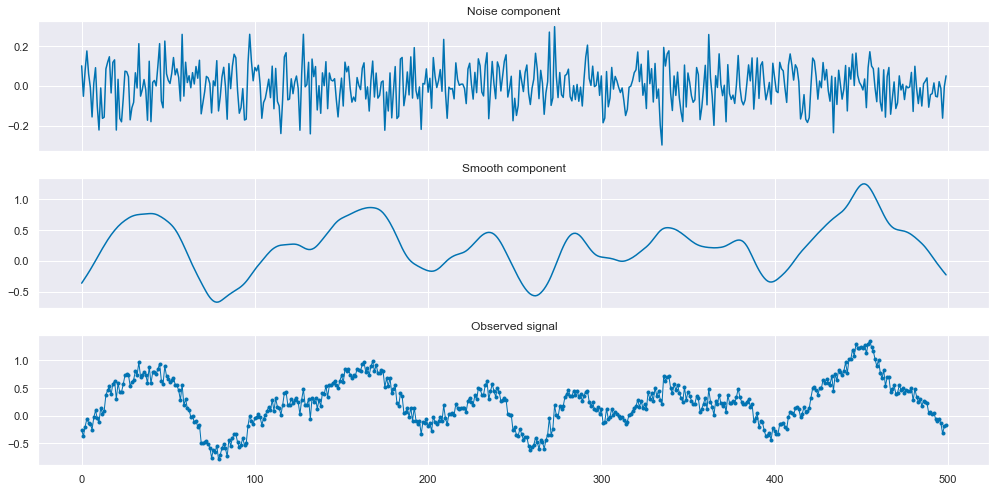

In [35]:
y = np.sum(X_real[:2], axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Noise component')
ax[0].plot(X_real[0])
ax[1].set_title('Smooth component')
ax[1].plot(X_real[1])
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

### Solve with CVXPY + MOSEK

In [36]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
components = [c1, c2]
problem = Problem(y, components)
problem.weights.value = [c.theta for c in problem.components]
problem.decompose(admm=False, solver='MOSEK')

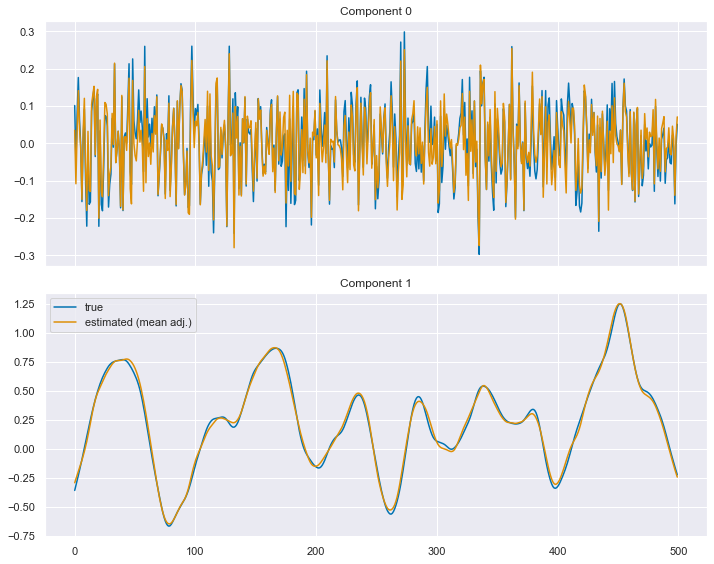

In [37]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    true = X_real[k]
    est = problem.estimates[k]
    ax[k].plot(true, label='true')
    ax[k].plot(est, label='estimated (mean adj.)')
    ax[k].set_title('Component {}'.format(k))
ax[k].legend()
plt.tight_layout()

### Solve with new ADMM formulation

This problem is comprised of quadratic terms and linear constraints, so everything goes in the z-update.

We have

$$ g(z,\tilde{z};\theta) = \left\lVert z_1 \right\rVert_2^2 + \theta\left\lVert \tilde{z}_2\right\rVert_2^2, $$

with

$$ \mathbf{dom}\,g = \left\{z,\tilde{z}\mid\sum_{k} z_k = y, D^2 z_2 = \tilde{z}_2\right\}.$$

Let $\hat{z} = \left[ \begin{matrix} z_1^T & z_2^T & \tilde{z}_2^T\end{matrix}\right]^T$. Then $g$ can be rewritten as


$$ g(\hat{z};P) = \hat{z}^T P \hat{z},$$

where $P\in\mathbf{R}^{(3T-2)\times(3T-2)}$ is a diagonal matrix with the first T entries equal to 1, the second T entris equal to 0, and the final T-1 entries equal to $\theta$.

In [129]:
# Initialization
X = np.zeros((K, T))
X[0] = y
X_tilde = np.zeros(T-2)
Z = np.copy(X)
Z_tilde = np.copy(X_tilde)
U = np.zeros_like(X)
U_tile = np.zeros_like(X_tilde)

In [198]:
d = np.zeros(3 * T - 2)
d[:T] = 1
d[2*T:] = 1e2
P = 2 * np.diag(d)
D = np.diff(np.eye(T), axis=0, n=2)

In [199]:
F_1 = np.block([np.eye(T), np.eye(T), np.zeros((T, T-2))])
F_2 = np.block([np.zeros((T-2, T)), D, -1 * np.eye(T-2)])
F = np.block([[F_1], [F_2]])

In [200]:
A = np.block([
    [P + np.eye(3*T - 2), F.T],
    [F, np.zeros((F.shape[0], F.shape[0]))]
])
A.shape

(2496, 2496)

In [202]:
v = np.random.randn(3 * T - 2)
g = np.block([y, np.zeros(T - 2)])
vp = np.block([v, g])

In [203]:
A_s = sp.csc_matrix(A)
A_factored = sp.linalg.splu(A_s)

In [204]:
first_solve = A_factored.solve(vp)
r = vp - A_s.dot(first_solve)
second_solve = first_solve + A_factored.solve(r)

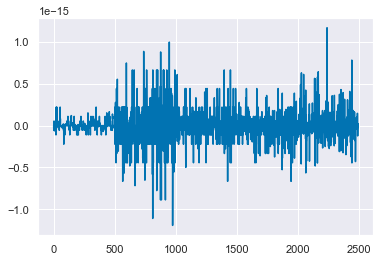

In [205]:
plt.plot(r)

In [206]:
x = cvx.Variable(3 * T - 2)
objective = cvx.Minimize(
    cvx.sum_squares(x[:T]) + 1e2 * cvx.sum_squares(x[2*T:]) + 0.5 * cvx.sum_squares(x - v)
)
constraints = [
    x[:T] + x[T:2*T] == y,
    cvx.diff(x[T:2*T], k=2) == x[2*T:]
]
problem = cvx.Problem(objective, constraints)
problem.solve(verbose=True, solver='MOSEK')



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1501            
  Cones                  : 3               
  Scalar variables       : 3500            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1501            
  Cones                  : 3               
  Scalar variables       : 3500            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 503
Optimizer  - Cones                  : 3
Optimizer  - Scalar variables

745.800193850406

In [207]:
objective.value

745.8001965027863

In [208]:
(cvx.sum_squares(first_solve[:T]) + 1e2 * cvx.sum_squares(first_solve[2*T:3*T-2]) + 0.5 * cvx.sum_squares(first_solve[:3*T-2] - v)).value

745.8001963134654

In [209]:
(cvx.sum_squares(second_solve[:T]) + 1e2 * cvx.sum_squares(second_solve[2*T:3*T-2]) + 0.5 * cvx.sum_squares(second_solve[:3*T-2] - v)).value

745.8001963134654

In [210]:
cvx_est = np.block([x.value, problem.constraints[0].dual_value, problem.constraints[1].dual_value])

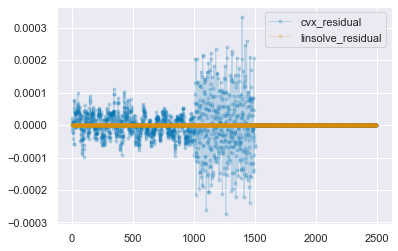

In [211]:
cvx_residual = A.dot(cvx_est) - vp
linsolve_residual = A.dot(first_solve) - vp
plt.plot(cvx_residual, linewidth=1, marker='.', alpha=0.2, label='cvx_residual')
plt.plot(linsolve_residual, linewidth=1, marker='.', alpha=0.2, label='linsolve_residual')
plt.legend();

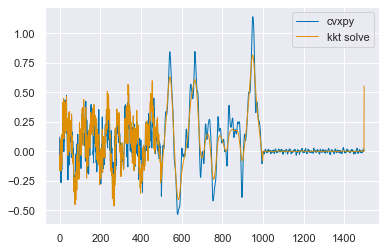

In [178]:
plt.plot(x.value, linewidth=1, label='cvxpy')
plt.plot(second_solve[:3*T-1], linewidth=1, label='kkt solve')
plt.legend();

In [179]:
np.alltrue([
    np.alltrue(np.isclose(second_solve[:T] + second_solve[T:2*T], y)),
    np.alltrue(np.isclose(x.value[:T] + x.value[T:2*T], y))
])

True

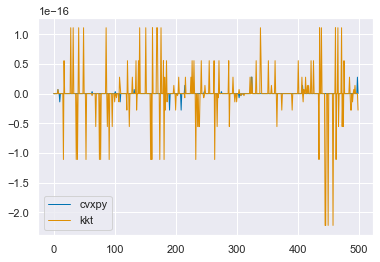

In [180]:
plt.plot(x.value[:T] + x.value[T:2*T] - y, linewidth=1, label='cvxpy')
plt.plot(second_solve[:T] + second_solve[T:2*T] - y, linewidth=1, label='kkt')
plt.legend();

In [181]:
np.alltrue([
    np.alltrue(np.isclose(np.diff(second_solve[T:2*T], n=2), second_solve[2*T:3*T-2])),
    np.alltrue(np.isclose(np.diff(x.value[T:2*T], n=2), x.value[2*T:]))
])

True

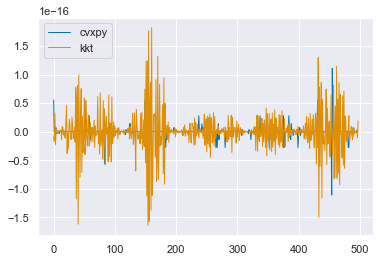

In [182]:
plt.plot(np.diff(x.value[T:2*T], n=2) - x.value[2*T:], linewidth=1, label='cvxpy')
plt.plot(np.diff(second_solve[T:2*T], n=2) - second_solve[2*T:3*T-2], linewidth=1, label='kkt')
plt.legend();

In [111]:
from scipy import sparse as sp

A_s = sp.csc_matrix(A)
A_s

<4996x4996 sparse matrix of type '<class 'numpy.float64'>'
	with 14982 stored elements in Compressed Sparse Column format>

In [112]:
%timeit sp.csc_matrix(A)

200 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
%timeit out_test = np.linalg.solve(A, vp)

997 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%timeit A_factored = sp.linalg.splu(A_s)

2.39 ms ± 61.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [115]:
A_factored = sp.linalg.splu(A_s)

In [116]:
%timeit sparse_test = A_factored.solve(vp)

516 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [117]:
A_factored = sp.linalg.splu(A_s)

In [118]:
sparse_test = A_factored.solve(vp)

In [157]:
r = vp - A_s.dot(sparse_test)
print(np.linalg.norm(r))

78.87682356281297


In [158]:
c = A_factored.solve(r)
x = sparse_test + c

In [159]:
r = vp - A_s.dot(x)
print(np.linalg.norm(r))

1.683334727408804e-14


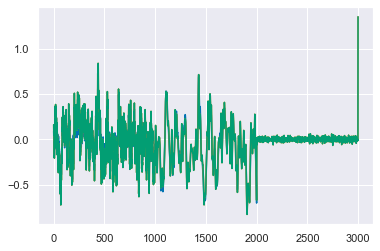

In [79]:
plt.plot(x.value)
plt.plot(out_test[:3*T-1])
plt.plot(sparse_test[:3*T-1])